## Sensitivity Test of Cloud-base Height, Finding the Corresponding Specific Humidity at Cloud-base, and the Precipitation Efficiency Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Constants
Cpv     = 1870   # Specific heat capacity of water vapor at constant pressure [J/kg/K] Bolton
Cw      = 4190   # Specific heat capacity of liquid water at constant pressure [J/kg/K] Bolton
Rv      = 461.5  # Gas constant for water vapor [J/kg/K]
Rd      = 287.04 # Gas constant for dry air [J/kg/K]
T0      = 273.15 # Reference temperature [K]

# q_zcb   = 0.016  # Initial specific humidity [kg/kg] constant below cloud base (sub-cloud)
# zcb     = 700    # Cloud base height [m]
zi      = 3000   # Inversion height [m]
ztop    = 4000   # Top of trade cumulus cloud layer [m]
divg    = 1e-6   # Divergence of vertical velocity [s^-1]
# rho_sfc = 1.16   # Surface density [kg/m^3]

Ecb     = 170    # Evaporation rate at cloud base [W/m^2]

In [3]:
# Functions
# Latent heat of vaporization of water as a function of temperature [K]
def Lv(T):
    return 2.501e6 + (Cpv - Cw) * (T - T0) # [J/kg]

# Wexler/Buck 1981 formula (with enhancement factor at standard pressure)
def es_wexler(T_C, P=1013.25):  # P in hPa
    return 1e2 * 6.1121 * (1.0007 + 3.46e-6 * P) * np.exp((17.502 * T_C) / (240.97 + T_C))

# Saturation vapor pressure calculations
def q_sat(T_C, p=101325):  # p in Pa (default = 1013.25 hPa)
    epsilon = Rd / Rv  # ratio of gas constants
    #es = es_clausius_clapeyron(T_C)
    #es = es_tetens(T_C)
    es = es_wexler(T_C, p / 100)
    return (epsilon * es) / (p - (1 - epsilon) * es)

# Total water content calculation
def q_total(ae, dz, x, qs, qm, q_zcb, izcb):
    qtilde = (1 - x) * qm + x * qs

    qt = qtilde.copy()
    qt[0:izcb+1] = q_zcb  # set sub-cloud specific humidity
                          # Python is start inclusive, end exclusive, so must use izcb+1
                          # So qt[0:izcb+1] includes qt[izcb]
    for iz in range(izcb, len(qt)-1):
        if qt[iz] > qs[iz]:
            a1 = ae * dz
            Q1 = (qtilde[iz+1] + qtilde[iz]) / 2
            qt[iz+1] = ( (1-a1/2) * qt[iz] + a1*Q1 ) / (1 + a1/2)
        else:
            a2 = (1 - x) * ae * dz
            Q2 = (qm[iz+1] + qm[iz]) / 2
            qt[iz+1] = ( (1-a2/2) * qt[iz] + a2*Q2 ) / (1 + a2/2)
    return qt

# def cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rho_L):
#     Q = x * ae * ql / (qs - qm) * dz
def cloudflux(ae, dz, x, ql, qm, qt, Ft, izcb, Ecb, rho_L):
    Q = x * ae * ql / (qt - qm) * dz
    Fcld = Ft.copy()
    Fcld[:] = np.nan
    Fcld[izcb] = Ecb / rho_L
    for iz in range(izcb, len(Fcld)-1):
        Fcld[iz+1] = (Ft[iz+1] - Ft[iz] + Fcld[iz] * (1 - Q[iz]/2)) / (1 + Q[iz+1]/2)
    return Fcld

In [4]:
# Data
path = "/Users/huang/Work/SimonsCAT"
dsr  = xr.open_dataset(f"{path}/RonBrown_radiosondes.nc")
dss  = xr.open_dataset(f"{path}/RonBrown_10min_flux.nc")

In [5]:
# Variables from datasets
# Mean profiles over soundings
z    = dsr['alt'].values       # shape (alt,) [m]
tam  = dsr['ta'].mean(dim='sounding', skipna=True).values
#thm  = dsr['theta'].mean(dim='sounding', skipna=True).values
qm   = dsr['q'].mean(dim='sounding', skipna=True).values
pm   = dsr['p'].mean(dim='sounding', skipna=True).values

# Mean fluxes over 10-min intervals
lhf  = dss['hl_bulk'].values.squeeze()  # surface downward latent heat flux [W/m^2]
pr   = dss['prate'].values.squeeze()    # precipitation rate [mm/hr]
rho  = dss['rhoair10'].values.squeeze()  # surface air density at 10-m [kg/m^3]
tair = dss['tair_ship'].values.squeeze()  # surface air temperature [degC]

# Variables derived from mean profiles
qs   = q_sat(tam - T0, pm)  # saturation specific humidity
dz   = (z[1] - z[0])        # vertical grid spacing in m
#dqdz = np.gradient(qm, dz)  # vertical gradient of specific humidity (central difference)
dqdz = np.diff(qm) / dz     #                                        (forward difference)
# Lv_m = Lv(np.nanmean(tam[z <= ztop])) # latent heat of vaporization avg lower than ztop [2.47e+6 J/kg]
Lvsfc_m = Lv(np.nanmean(tair) + T0)  # latent heat of vaporization at surface [2.44e+6 J/kg]

rho_sfc = np.nanmean(rho)  # surface air density [kg/m^3]
rhosfc_L = rho_sfc * Lvsfc_m

E0   = -np.nanmean(lhf)                       # surface evaporation rate [180.58 W/m^2]
P0   = rhosfc_L * np.nanmean(pr) / 3600 # surface precipitation rate [25.44 W/m^2]
print(f"Surface evaporation rate: {E0:.2f} W/m^2")
print(f"Surface precipitation rate: {P0:.2f} W/m^2")

Surface evaporation rate: 180.58 W/m^2
Surface precipitation rate: 25.40 W/m^2


### Sensitivity of Cloud-base Height ($z_{cb}$)
- Taking from 400-m to 1000-m
- First find the specific humidity at the cloud-base ($q_{zcb}$)
- Integrate upward from the cloud-base with fixed $\alpha+\epsilon$ = 1.5 $km^{-1}$
    - $\alpha$: auto-conversion rate
    - $\epsilon$: entrainment rate
- Need to find the precipitation efficiency ($x$) in order to satisfy that precipitation goes to zero at cloud-top ($x$ is NOT a constant, it varys with different selection of cloud-base height)

In [6]:
# Cloud base height and initial specific humidity
zcb   = np.linspace(400, 1000, 13)       # A range of cloud base height [m]

# Find q_zcb based on zcb and qs
q_zcb = np.zeros(len(zcb))  # Initialize array for specific humidity at cloud base height
for jzcb in range(len(zcb)):
    izcb = np.where(z >= zcb[jzcb])[0][0]  # find index where height is greater than or equal to zcb
    q_zcb[jzcb] = qs[izcb]  # specific humidity at cloud base height
    print(f"Cloud base height: {zcb[jzcb]} m, Specific humidity at cloud base: {q_zcb[jzcb]:.4f} kg/kg")

Cloud base height: 400.0 m, Specific humidity at cloud base: 0.0171 kg/kg
Cloud base height: 450.0 m, Specific humidity at cloud base: 0.0168 kg/kg
Cloud base height: 500.0 m, Specific humidity at cloud base: 0.0164 kg/kg
Cloud base height: 550.0 m, Specific humidity at cloud base: 0.0161 kg/kg
Cloud base height: 600.0 m, Specific humidity at cloud base: 0.0157 kg/kg
Cloud base height: 650.0 m, Specific humidity at cloud base: 0.0154 kg/kg
Cloud base height: 700.0 m, Specific humidity at cloud base: 0.0152 kg/kg
Cloud base height: 750.0 m, Specific humidity at cloud base: 0.0149 kg/kg
Cloud base height: 800.0 m, Specific humidity at cloud base: 0.0147 kg/kg
Cloud base height: 850.0 m, Specific humidity at cloud base: 0.0145 kg/kg
Cloud base height: 900.0 m, Specific humidity at cloud base: 0.0143 kg/kg
Cloud base height: 950.0 m, Specific humidity at cloud base: 0.0141 kg/kg
Cloud base height: 1000.0 m, Specific humidity at cloud base: 0.0139 kg/kg


In [7]:
# Calculations: large-scale advections (prescribed, i.e., the A term)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
w_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdz  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

ls_adv = w_dqdz + u_dqdx

In [8]:
# Calculations: divergence of moisture fluxes
# rho_L = np.nanmean(pm[z <= ztop]) / (Rd * np.nanmean(tam[z <= ztop])) * Lv_m # Density times Lv [kg/m^3 J/kg]

# Total moisture flux at cloud base
Fcb   = Ecb / rhosfc_L - np.nanmean(pr) / 3600 # [kg/kg m/s]

Control case with α+ϵ= 1.5 1/km
----------------
Cloud base height: 400.0 m
Found x = 0.382916 satisfying cloud base at 400.0 m
Cloud top height: 1900.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000001115 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: -0.000000000005 kg/kg m/s

Entrainment coefficient (ec): 0.925626 1/km
Autoconversion coefficient (ac): 0.574374 1/km
----------------
Cloud base height: 450.0 m
Found x = 0.408060 satisfying cloud base at 450.0 m
Cloud top height: 1920.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000000571 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: -0.000000000009 kg/kg m/s

Entrainment coefficient (ec): 0.887911 1/km
Autoconversion coefficient (ac): 0.612089 1/km
----------------
Cloud base height: 500.0 m
Found x = 0.437180 satisfying cloud base at 500.0 m
Cloud top height: 1930.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000001186 kg/kg m/s
Precipitation flux (Fcld - 

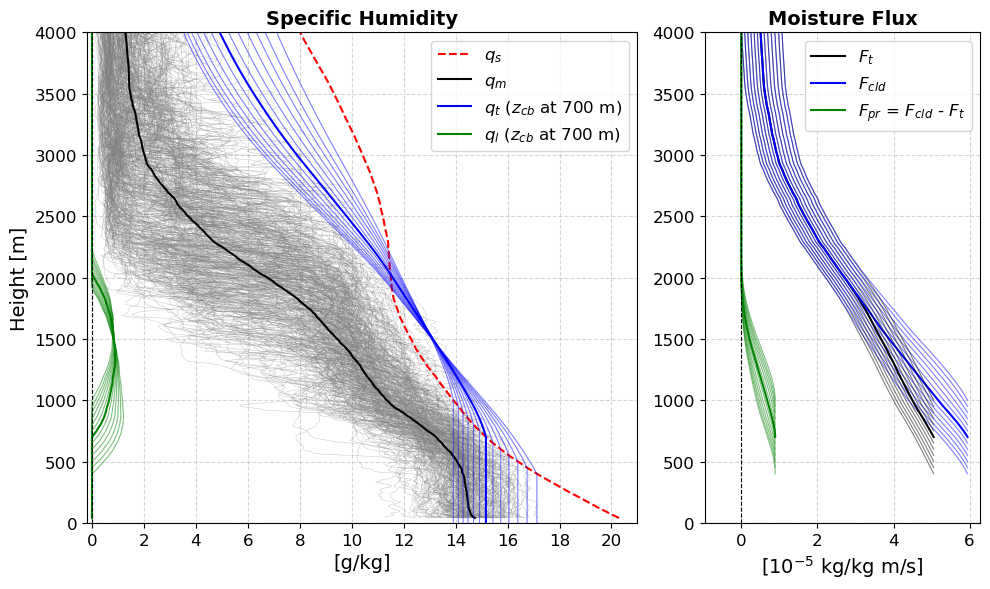

In [9]:
# Calculations: moisture budget for control case (α+ϵ = 1.5 1/km)

### --- Plot --- ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.3, alpha=0.5)
ax1.plot(qs*1000, z, color='r', linestyle='--', linewidth=1.5, label='$q_s$')
ax1.plot(qm*1000, z, color='k', linewidth=1.5, label='$q_m$')
### --- Plot --- ###

# Total sinking rate (entrainment + autoconversion)
ae = 1.5e-3       # ec + ac [1/m]
print(f"Control case with α+ϵ= {ae*1e+3} 1/km")

# Start binary search for each cloud base height
for jzcb in range(len(zcb)):
    print('----------------')
    print(f"Cloud base height: {zcb[jzcb]} m")
    izcb = np.where(z >= zcb[jzcb])[0][0]  # find index where height is greater than or equal to zcb

    # Integrate total flux balancing subsidence drying and horizontal advection from cloud base
    Ft = qm.copy()
    Ft[1:izcb] = np.nan
    ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv[izcb:] * dz)) )
    Ft[izcb:] = Fcb + ls_adv_cumsum
    if zcb[jzcb] == 700:
        print(Ft[~np.isnan(Ft)])

    # Selecting precipitation efficiency x
    x_min = 0.0
    x_max = 1.0
    tol = 1e-6  # Tolerance for convergence
    while (x_max - x_min) > tol*1e-1:
        x = (x_min + x_max) / 2

        # Calculate total water content
        qt = q_total(ae, dz, x, qs, qm, q_zcb[jzcb], izcb)
        ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

        # Find the cloud-top height where ql goes to zero above the cloud base
        izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb

        # Calculations: cloud fluxes for control case
        # Fcld = cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rhosfc_L)
        Fcld = cloudflux(ae, dz, x, ql, qm, qt, Ft, izcb, Ecb, rhosfc_L)
        Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

        # Check if the precipitation flux condition is satisfied
        if Fpr[izct-1] >= 0 and Fpr[izct] <= 0 and (x_max - x_min) < tol:
            print(f"Found x = {x:.6f} satisfying cloud base at {zcb[jzcb]} m")
            print(f"Cloud top height: {z[izct]:.2f} m")
            print(f'Precipitation flux (Fcld - Ft) at just below cloud top: {Fpr[izct-1]:.12f} kg/kg m/s')
            print(f'Precipitation flux (Fcld - Ft) at cloud top: {Fpr[izct]:.12f} kg/kg m/s')
            break
        elif Fpr[izct] > 0:
            x_min = x
        else:
            x_max = x

    ### --- Plot --- ###
    if zcb[jzcb] == 700:
        ax1.plot(qt*1000, z, color='b', linewidth=1.5, label=f'$q_t$ ($z_{{cb}}$ at {zcb[jzcb]:.0f} m)')
        ax1.plot(ql*1000, z, color='g', linewidth=1.5, label=f'$q_l$ ($z_{{cb}}$ at {zcb[jzcb]:.0f} m)')
    else:
        ax1.plot(qt*1000, z, color='b', linewidth=0.8, alpha=0.5)
        ax1.plot(ql*1000, z, color='g', linewidth=0.8, alpha=0.5)

    ax1.set_xlim(-0.2, 21)
    ax1.set_ylim(0, 4000)
    xticks = np.arange(0, 21, 2)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.set_xlabel('[g/kg]', fontsize=14)
    ax1.set_ylabel('Height [m]', fontsize=14)
    ax1.set_title('Specific Humidity', fontsize=14, fontweight='bold')
    ax1.grid(linestyle='--', alpha=0.5)

    if zcb[jzcb] == 700:
        ax2.plot(Ft*1e+5, z, color='k', linewidth=1.5, label='$F_t$')
        ax2.plot(Fcld*1e+5, z, color='b', linewidth=1.5, label='$F_{cld}$')
        ax2.plot((Fcld-Ft)*1e+5, z, color='g', linewidth=1.5, label='$F_{pr}$ = $F_{cld}$ - $F_t$')
    else:
        ax2.plot(Ft*1e+5, z, color='k', linewidth=0.8, alpha=0.5)
        ax2.plot(Fcld*1e+5, z, color='b', linewidth=0.8, alpha=0.5)
        ax2.plot((Fcld-Ft)*1e+5, z, color='g', linewidth=0.8, alpha=0.5)

    #ax2.set_xlim(-0.1, 6)
    ax2.set_ylim(0, 4000)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_xlabel(r'[$10^{-5}$ kg/kg m/s]', fontsize=14)
    ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
    ax2.grid(linestyle='--', alpha=0.5)
    ### --- Plot --- ###

    ec = (1 - x) * ae # entrainment coefficient
    ac = x * ae       # autoconversion coefficient
    print('')
    print(f"Entrainment coefficient (ec): {ec*1000:.6f} 1/km")
    print(f"Autoconversion coefficient (ac): {ac*1000:.6f} 1/km")

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')
ax2.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()


### Various combinations of $\alpha+\epsilon$
- $\alpha+\epsilon$ varys from 6 to 0.766563 $km^{-1}$ (0.766563 is where we can have the highest cloud-top)
- For this experiment, cloud-base height ($z_{cb}$) is chosen to be 700-m with specific humidify ($q_{zcb}$) equals 0.0152 $kg/kg$
- Again, the precipitation efficiency ($x$) is NOT a constant here. In order to satisfy that precipitation goes to zero at cloud-top, we need to find $x$ for each combination of $\alpha+\epsilon$

----------------------------------------
Case with α+ϵ= 6.0 1/km
----------------------------------------
Cloud base height: 700 m
Found x = 0.802872 satisfying cloud base at 700 m
Cloud top height: 1450.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000011467 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: -0.000000000022 kg/kg m/s

Entrainment coefficient (ec): 1.182769 1/km
Autoconversion coefficient (ac): 4.817231 1/km

----------------------------------------
Case with α+ϵ= 5.781940125 1/km
----------------------------------------
Cloud base height: 700 m
Found x = 0.796755 satisfying cloud base at 700 m
Cloud top height: 1460.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000007611 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: 0.000000000000 kg/kg m/s

Entrainment coefficient (ec): 1.175153 1/km
Autoconversion coefficient (ac): 4.606787 1/km

----------------------------------------
Case with α+ϵ= 5.563880250000001 1/km
------

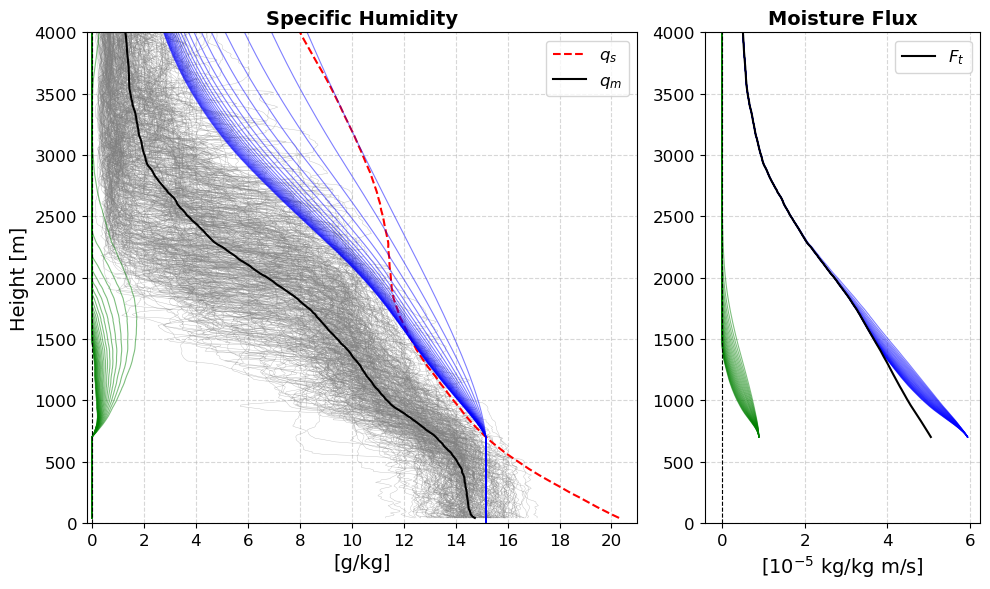

In [10]:
# Calculations: moisture budget for multiple cases
zcb = [700]

### --- Plot --- ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.3, alpha=0.5)
ax1.plot(qs*1000, z, color='r', linestyle='--', linewidth=1.5, label='$q_s$')
ax1.plot(qm*1000, z, color='k', linewidth=1.5, label='$q_m$')
### --- Plot --- ###

# Total sinking rate (entrainment + autoconversion)
aeo = 1e-3 * np.linspace(6, 0.766563, 25)       # ec + ac [1/m]

x_out = []
a_out = []
e_out = []
for iae in range(len(aeo)):
    print('-' * 40)
    print(f"Case with α+ϵ= {aeo[iae]*1e+3} 1/km")
    ae = aeo[iae]

    # Start binary search for each cloud base height
    for jzcb in range(len(zcb)):
        print('-' * 40)
        print(f"Cloud base height: {zcb[jzcb]} m")
        izcb = np.where(z >= zcb[jzcb])[0][0]  # find index where height is greater than or equal to zcb
        q_zcb = qs[izcb]  # specific humidity at cloud base height

        # Integrate total flux balancing subsidence drying and horizontal advection from cloud base
        Ft = qm.copy()
        Ft[1:izcb] = np.nan
        ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv[izcb:] * dz)) )
        Ft[izcb:] = Fcb + ls_adv_cumsum

        # === Selecting precipitation efficiency x
        x_min = 0.0
        x_max = 1.0
        tol = 1e-7  # Tolerance for convergence
        while (x_max - x_min) > tol or Fpr[izct] > 0:
            x = (x_min + x_max) / 2

            # Calculate total water content
            qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
            ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

            # Find the cloud-top height where ql goes to zero above the cloud base
            izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb

            # Calculations: cloud fluxes for control case
            # Fcld = cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rhosfc_L)
            Fcld = cloudflux(ae, dz, x, ql, qm, qt, Ft, izcb, Ecb, rhosfc_L)
            Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

            # Check if the precipitation flux condition is satisfied
            if Fpr[izct-1] >= 0 and Fpr[izct] <= 0 and (x_max - x_min) < tol:
                break
            elif Fpr[izct] > 0:
                x_min = x
            else:
                x_max = x
        
        print(f"Found x = {x:.6f} satisfying cloud base at {zcb[jzcb]} m")
        print(f"Cloud top height: {z[izct]:.2f} m")
        print(f'Precipitation flux (Fcld - Ft) at just below cloud top: {Fpr[izct-1]:.12f} kg/kg m/s')
        print(f'Precipitation flux (Fcld - Ft) at cloud top: {Fpr[izct]:.12f} kg/kg m/s')
        
        # ===

        # === Fixed precipitation efficiency x ===
        # x = 0.520649
        # # Calculate total water content
        # qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
        # ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

        # # Find the cloud-top height where ql goes to zero above the cloud base
        # izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb

        # # Calculations: cloud fluxes for control case
        # Fcld = cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rho_L)
        # Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top
        # ===

        # Output x
        x_out.append(x)

        ### --- Plot --- ###
        ax1.plot(qt*1000, z, color='b', linewidth=0.8, alpha=0.5)
        ax1.plot(ql*1000, z, color='g', linewidth=0.8, alpha=0.5)

        ax2.plot(Fcld*1e+5, z, color='b', linewidth=0.8, alpha=0.5)
        ax2.plot((Fcld-Ft)*1e+5, z, color='g', linewidth=0.8, alpha=0.5)
        ### --- Plot --- ###

    ### --- Plot --- ###
    ax1.set_xlim(-0.2, 21)
    ax1.set_ylim(0, 4000)
    xticks = np.arange(0, 21, 2)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.set_xlabel('[g/kg]', fontsize=14)
    ax1.set_ylabel('Height [m]', fontsize=14)
    ax1.set_title('Specific Humidity', fontsize=14, fontweight='bold')
    ax1.grid(linestyle='--', alpha=0.5)

    #ax2.set_xlim(-0.1, 6)
    ax2.set_ylim(0, 4000)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_xlabel(r'[$10^{-5}$ kg/kg m/s]', fontsize=14)
    ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
    ax2.grid(linestyle='--', alpha=0.5)
    ### --- Plot --- ###

    ec = (1 - x) * ae # entrainment coefficient
    ac = x * ae       # autoconversion coefficient
    a_out.append(ac)
    e_out.append(ec)
    print('')
    print(f"Entrainment coefficient (ec): {ec*1000:.6f} 1/km")
    print(f"Autoconversion coefficient (ac): {ac*1000:.6f} 1/km\n")

ax2.plot(Ft*1e+5, z, color='k', linewidth=1.5, label=f'$F_t$')

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')
ax2.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()


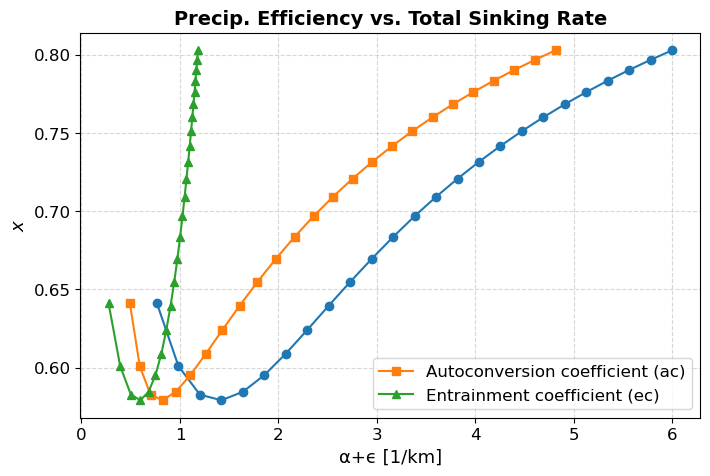

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(aeo*1e+3, x_out, marker='o')
plt.plot(np.array(a_out)*1e+3, x_out, marker='s', label='Autoconversion coefficient (ac)')
plt.plot(np.array(e_out)*1e+3, x_out, marker='^', label='Entrainment coefficient (ec)')

plt.xlabel('α+ϵ [1/km]', fontsize=13)
plt.ylabel('$x$', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Precip. Efficiency vs. Total Sinking Rate', fontsize=14, fontweight='bold')
plt.grid(linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

### Actual Onion Plot with $x$ and $\alpha+\epsilon$

In [12]:
# α+ϵ varies from 0.766563 to 6
aeo = 1e-3 * np.linspace(6, 0.766563, 25)

x_out = []
for iae in range(len(aeo)):
    ae = aeo[iae]
    # === Selecting precipitation efficiency x
    x_min = 0.0
    x_max = 1.0
    tol = 1e-6  # Tolerance for convergence
    while (x_max - x_min) > tol*1e-1:
        x = (x_min + x_max) / 2

        # Calculate total water content
        qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
        ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

        # Find the cloud-top height where ql goes to zero above the cloud base
        izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb

        # Calculations: cloud fluxes for control case
        # Fcld = cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rhosfc_L)
        Fcld = cloudflux(ae, dz, x, ql, qm, qt, Ft, izcb, Ecb, rhosfc_L)
        Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

        # Check if the precipitation flux condition is satisfied
        if Fpr[izct-1] >= 0 and Fpr[izct] <= 0 and (x_max - x_min) < tol:
            break
        elif Fpr[izct] > 0:
            x_min = x
        else:
            x_max = x

    print(f"Found x = {x:.6f} satisfying cloud base at {zcb[jzcb]} m")
    print(f"Cloud top height: {z[izct]:.2f} m")
    print(f'Precipitation flux (Fcld - Ft) at just below cloud top: {Fpr[izct-1]:.12f} kg/kg m/s')
    print(f'Precipitation flux (Fcld - Ft) at cloud top: {Fpr[izct]:.12f} kg/kg m/s')
    # ===
    x_out.append(x)

#eco = (1 - x_out) * aeo
#aco = x_out * aeo

# Calculate total water content for each case
print("3. Multiple cases...")
qto = [q_total(ae, dz, x, qs, qm, q_zcb, izcb) for (x, ae) in zip(x_out, aeo)]
qlo = [np.maximum(qt_case - qs, 0.0) for qt_case in qto]

# Find the cloud-top heights for each case
izcts = [np.where(ql_case[izcb+1:] == 0)[0][0] for ql_case in qlo]
zcts = [z[cloud_index + izcb] if cloud_index.size > 0 else 'No cloud top found' for cloud_index in izcts]
# Print cloud top heights for each case
for i, (height, x) in enumerate(zip(zcts, x_out)):
    print(f"Cloud top height for case {i+1} (α+ϵ = {aeo[i]*1e+3:.2f}): {height} km (x={x:.6f})")

# Examine if there's non-zero cloud liquid water content above the cloud top height for each case
for i, (qt_case, ql_case) in enumerate(zip(qto, qlo)):
    if izcts[i].size > 0:
        cth = z[izcts[i] + izcb]
        if np.any(ql_case[izcts[i] + izcb+1:] > 0):
            print(f"Cloud liquid water content becomes non-zero at some point above the cloud top height of {cth} km for case {i+1}.")
        else:
            print(f"Cloud liquid water content is zero above the cloud top height of {cth} km for case {i+1}.")

Found x = 0.802872 satisfying cloud base at 700 m
Cloud top height: 1450.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000011456 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: -0.000000000033 kg/kg m/s
Found x = 0.796755 satisfying cloud base at 700 m
Cloud top height: 1460.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000007611 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: 0.000000000000 kg/kg m/s
Found x = 0.790292 satisfying cloud base at 700 m
Cloud top height: 1470.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000005071 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: -0.000000000044 kg/kg m/s
Found x = 0.783441 satisfying cloud base at 700 m
Cloud top height: 1480.00 m
Precipitation flux (Fcld - Ft) at just below cloud top: 0.000000004355 kg/kg m/s
Precipitation flux (Fcld - Ft) at cloud top: -0.000000000022 kg/kg m/s
Found x = 0.776139 satisfying cloud base at 700 m
Cloud top height: 1500.00 m
Pre

Text(1, 3.3, '(to satisfy that precip must \ngo to zero above cloud top)')

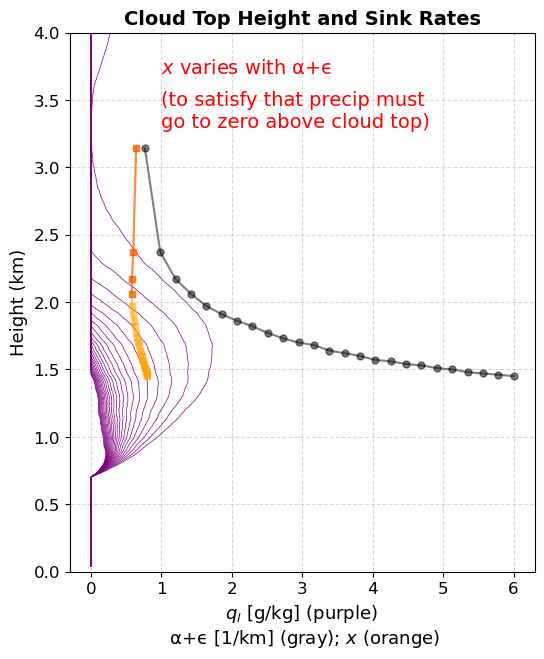

In [13]:
plt.figure(figsize=(6, 7))

for il in range(len(qlo)):
    plt.plot(qlo[il]*1000, z/1000, color='purple', linewidth=0.5, label=f'α+ϵ={aeo[il]*1e+3:.1f} 1/km')

plt.plot(aeo*1e+3, np.array(zcts)/1000, marker='o', color='k', linestyle='-', alpha=0.5,
         markersize=5, linewidth=1.5, label='Cloud Top Height')
plt.plot(np.array(x_out), np.array(zcts)/1000, marker='s', color='orange', linestyle='-', alpha=0.5,
         markersize=5, linewidth=1.5, label='Cloud Top Height')
plt.plot(np.array(x_out)[-4:], np.array(zcts)[-4:]/1000, marker='s', color='orangered', linestyle='-', alpha=0.5,
         markersize=5, linewidth=1.5, label='Cloud Top Height')

plt.ylim(0, 4)
plt.xlabel('$q_l$ [g/kg] (purple) \n α+ϵ [1/km] (gray); $x$ (orange)', fontsize=13)
plt.ylabel('Height (km)', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Cloud Top Height and Sink Rates', fontsize=14, fontweight='bold')
plt.grid(linestyle='--', alpha=0.5)

plt.text(1, 3.7, f'$x$ varies with α+ϵ', fontsize=14, color='r')
plt.text(1, 3.3, f'(to satisfy that precip must \ngo to zero above cloud top)', fontsize=14, color='r')